## Estimate the time decay coefficient for a gravity-based job accessibility index

I construct a job accessibility index for lower-paying jobs within each census tract in Georgia, for a research titled ["Assessing Racial Disparities in TANF Recipients’ Job Access and Its Implications for Health-Related Outcomes"](https://issuu.com/rc-t/docs/xula_poster_v3) focusing on those earning $1250 or less per month. The model is grounded in a gravity-based framework as outlined by [Blumenberg et al. (2003)](https://escholarship.org/uc/item/0g04h3rt). However, I've opted for a distinct time decay function, which is expressed by the following formula:

$$
A_{i} = \sum_{j} \left[ \frac{E_{j} \cdot f(d_{ij})}{\sum_{k} P_{k} \cdot f(d_{jk})} \right]
$$

$A_{i}$ = job accessibility in census tract 𝑖 (measured census tract)

$E_{j}$ = number of jobs in census tract 𝑗

$P_{k}$ = number of jobseekers (job competitors) in census tract 𝑘

$f(d_{ij} = e^{-\beta(k) \cdot t}$ (time decay funtion, $b$ = non-negative time decay coefficient, $t$ = travel time in minute, $k$ = area type)

_Note. Area type is categorized as Metropolitan area, Small town, or Rural area based on USDA Rural-Urban Commuting Area Codes_

<br>

The job accessibility index is formulated on a gravity-based measure, utilizing a travel time threshold of 30 minutes. Conceptually, the formula imposes a penalty on job accessibility proportional to the travel time between workers' residences and job locations. Importantly, this formula integrates considerations of job competition. Higher competition for a job makes it more accessible to other job seekers, thus lowering its accessibility score.

Moreover, the time decay function can be understood as representing the ease of accessing a job. As distance from the job increases, the difficulty of reaching it escalates. This is modulated by the parameter $b$, which is a non-negative time decay coefficient.

In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from IPython.display import display, Image

I use LEHD data to calculate the number of jobs at each census tract. This linked employer-employee data cover over 95% of employment in the United States.

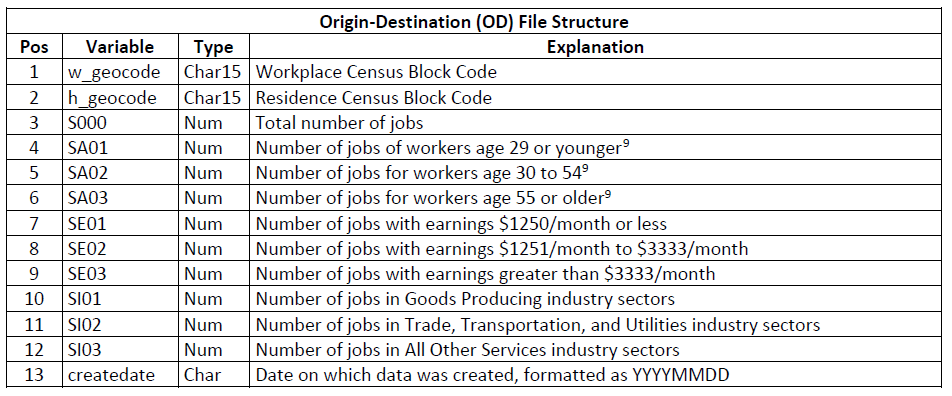

In [2]:
# lehd data structure, learn more about lehd data structure on https://lehd.ces.census.gov/data/lodes/LODES8/LODESTechDoc8.1.pdf
display(Image(filename="D:/data/lehd.png"))

### Get the number of lower-paying jobs at census tract

In [3]:
# Read in data
df = pd.read_csv("D:\M.S. GIS\Georgia Tech\GRA\CQGRD\Job_Accessibility\ga_od_main_JT01_2021.csv")
df

,w_geocode,h_geocode,S000,SA01,SA02,SA03,SE01,SE02,SE03,SI01,SI02,SI03,createdate
0,130019501001000,130019501001000,2,1,0,1,0,1,1,1,1,0,20231016
1,130019501001000,130019501001009,4,1,2,1,1,0,3,2,2,0,20231016
2,130019501001000,130019501001012,1,1,0,0,0,0,1,0,1,0,20231016
3,130019501001000,130019501001017,1,0,1,0,0,0,1,0,1,0,20231016
4,130019501001000,130019501001019,1,0,1,0,0,0,1,0,1,0,20231016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3545052,133219506002050,130719702001014,1,1,0,0,0,1,0,1,0,0,20231016
3545053,133219506002050,130719703011003,1,0,0,1,0,1,0,1,0,0,20231016
3545054,133219506002050,130719703012030,1,0,0,1,0,1,0,1,0,0,20231016
3545055,133219506002050,130950116001030,1,0,1,0,0,1,0,1,0,0,20231016


In [4]:
# Use the number of workers employed at the workplace census block code as a measure of the number of jobs within that census block
df_job = df[['w_geocode', 'SE01']].copy()

# Aggregate jobs from block to census tract level at workplace census tract ID
df_job['CT_GEOID'] = df_job['w_geocode'].astype(str).str[:11]
df_job['Job'] = df_job.groupby('CT_GEOID')['SE01'].transform('sum')
df_job = df_job.drop_duplicates(subset=['CT_GEOID'])

# Check if the jobs in the subset add up correctly
print("------------------------------------------")
print(df_job['Job'].sum() == df['SE01'].sum())

# Reset index
df_job = df_job.reset_index()
df_job = df_job[['CT_GEOID', 'Job']]
df_job

------------------------------------------
True


,CT_GEOID,Job
0,13001950100,50
1,13001950201,50
2,13001950202,291
3,13001950301,369
4,13001950302,230
...,...,...
2781,13321950201,27
2782,13321950202,256
2783,13321950400,84
2784,13321950500,175


### Get the number of lower-paying workers at census tract

In [5]:
df_worker = df[['h_geocode', 'SE01']].copy()

# Aggregate jobs from block to census tract level at residence census tract ID
df_worker['CT_GEOID'] = df_worker['h_geocode'].astype(str).str[:11]
df_worker['Worker'] = df_worker.groupby('CT_GEOID')['SE01'].transform('sum')
df_worker = df_worker.drop_duplicates(subset=['CT_GEOID'])

# Check if the jobs in the subset add up correctly
print("------------------------------------------")
print(df_worker['Worker'].sum() == df['SE01'].sum())

# Reset index
df_worker = df_worker.reset_index()
df_worker = df_worker[['CT_GEOID', 'Worker']]
df_worker

------------------------------------------
True


,CT_GEOID,Worker
0,13001950100,166
1,13001950201,155
2,13001950202,185
3,13001950301,213
4,13001950302,196
...,...,...
2786,13121011204,110
2787,13121006400,77
2788,13089980000,15
2789,13063980000,13


### Travel time decay coefficient

I adopt the methodology outlined by [Iacono et al. (2008)](https://hdl.handle.net/11299/151329) to estimate the travel time decay coefficient. This method entails fitting an exponential decay curve to the midpoint of each bin in the histogram. I estimate three time decay coefficients in total, corresponding to Metropolitan, Small town, and Rural areas, respectively.

One might observe that the coefficient is influenced by the number of bins specified for the histogram. Therefore, I utilize the [Freedman–Diaconis rule](https://en.wikipedia.org/wiki/Freedman%E2%80%93Diaconis_rule) to ascertain the optimal bin width and subsequently determine the optimal number of bins. $IQR(x)$ is the interquartile of the data.

$$
\text{Bin width} = 2 \frac{IQR(x)}{\sqrt[3]{n}}
$$

### Travel time decay coefficient for _Metropolitan_ area

Optimal number of bins: 27


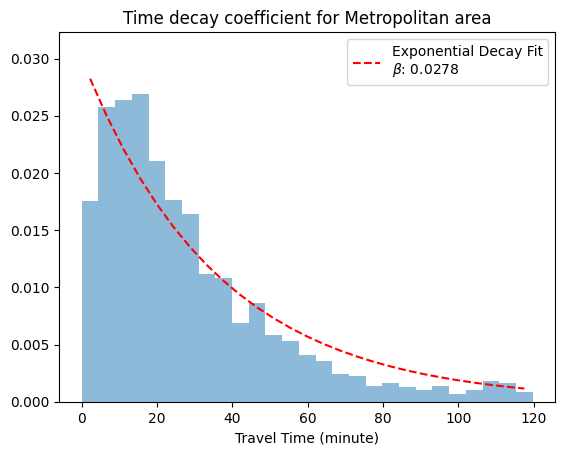

Time decay coefficient: 0.0278
R-squared value: 0.87


In [6]:
# Read in data
ttd = pd.read_csv("D:/M.S. GIS/Georgia Tech/GRA/CQGRD/Job_Accessibility/Metropolitan.csv")

# Filter out work trips that are larger than 2 hours
ttd = ttd.loc[ttd['Total_TravelTime'] <= 120]

# Interquartile travel time for Metropolitan census tracts
q75, q25 = np.percentile(ttd['Total_TravelTime'], [75 ,25])
iqr = q75 - q25

# Optimal bin width
onb = 2 * iqr/(len(ttd['Total_TravelTime']) ** (1/3))

# Optimal number of bins for Metropolitan area estimate
opb_m = round((np.max(ttd['Total_TravelTime']) - np.min(ttd['Total_TravelTime'])) / onb)
print(f'Optimal number of bins: {opb_m}')

# Define exponential decay function
def exponential_decay(x, a, b):
    return a * np.exp(-b * x)

# Extracting histogram data
counts, bin_edges = np.histogram(ttd['Total_TravelTime'], bins=opb_m, density=True)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Fit the data to the exponential decay function using bin centers as x values
popt, pcov = curve_fit(exponential_decay, bin_centers, counts, p0=(1, 1))

# Extract the parameters
a_fit, b_fit = popt

# Plot the histogram
plt.hist(ttd['Total_TravelTime'], bins=opb_m, density=True, alpha=0.5)

# Plot the fitted exponential decay curve using bin centers
plt.plot(bin_centers, exponential_decay(bin_centers, *popt), 'r--', label=f'Exponential Decay Fit\n$\\beta$: {b_fit:.4f}')

# Set y-axis limits to ensure both histogram and fit line are visible
plt.xlabel('Travel Time (minute)')
plt.ylim(0, max(counts)*1.2)

# Show the plot with legend
plt.title('Time decay coefficient for Metropolitan area')
plt.legend()
plt.savefig('D:/Capstone/Metropolitan.png', bbox_inches='tight')
plt.show()

# Calculate R-squared value
predicted_values = exponential_decay(bin_centers, *popt)
R_squared = r2_score(counts, predicted_values)

print(f'Time decay coefficient: {round(b_fit, 4)}')
print("R-squared value:", round(R_squared, 2))

### Travel time decay coefficient for _Small town_

Optimal number of bins: 21


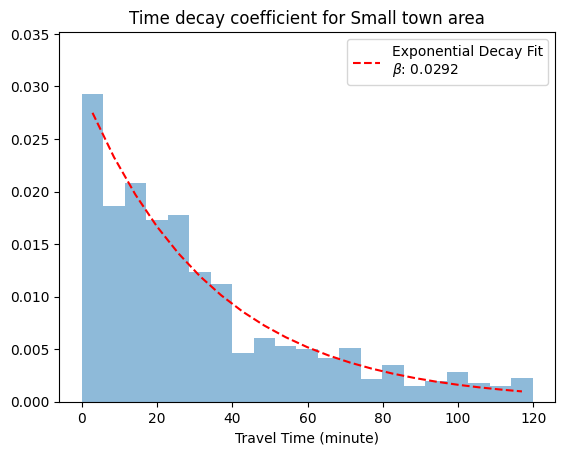

Time decay coefficient: 0.0292
R-squared value: 0.95


In [7]:
# Read in data
ttd = pd.read_csv("D:/M.S. GIS/Georgia Tech/GRA/CQGRD/Job_Accessibility/Smalltown.csv")

# Filter out work trips that are larger than 2 hours
ttd = ttd.loc[ttd['Total_TravelTime'] <= 120]

# Interquartile travel time for Metropolitan census tracts
q75, q25 = np.percentile(ttd['Total_TravelTime'], [75 ,25])
iqr = q75 - q25

# Optimal bin width
onb = 2 * iqr/(len(ttd['Total_TravelTime']) ** (1/3))

# Optimal number of bins for small town area estimate
opb_s = round((np.max(ttd['Total_TravelTime']) - np.min(ttd['Total_TravelTime'])) / onb)
print(f'Optimal number of bins: {opb_s}')

# Define exponential decay function
def exponential_decay(x, a, b):
    return a * np.exp(-b * x)

# Extracting histogram data
counts, bin_edges = np.histogram(ttd['Total_TravelTime'], bins=opb_s, density=True)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Fit the data to the exponential decay function using bin centers as x values
popt, pcov = curve_fit(exponential_decay, bin_centers, counts, p0=(1, 0.01))

# Extract the parameters
a_fit, b_fit = popt

# Plot the histogram
plt.hist(ttd['Total_TravelTime'], bins=opb_s, density=True, alpha=0.5)

# Plot the fitted exponential decay curve using bin centers
plt.plot(bin_centers, exponential_decay(bin_centers, *popt), 'r--', label=f'Exponential Decay Fit\n$\\beta$: {b_fit:.4f}')

# Set y-axis limits to ensure both histogram and fit line are visible
plt.xlabel('Travel Time (minute)')
plt.ylim(0, max(counts)*1.2)

# Show the plot with legend
plt.title('Time decay coefficient for Small town area')
plt.legend()
plt.savefig('D:/Capstone/Smalltown.png', bbox_inches='tight')
plt.show()

# Calculate R-squared value
predicted_values = exponential_decay(bin_centers, *popt)
R_squared = r2_score(counts, predicted_values)

print(f'Time decay coefficient: {round(b_fit, 4)}')
print("R-squared value:", round(R_squared, 2))


### Travel time decay coefficient for _Rural_ area

Optimal number of bins: 22


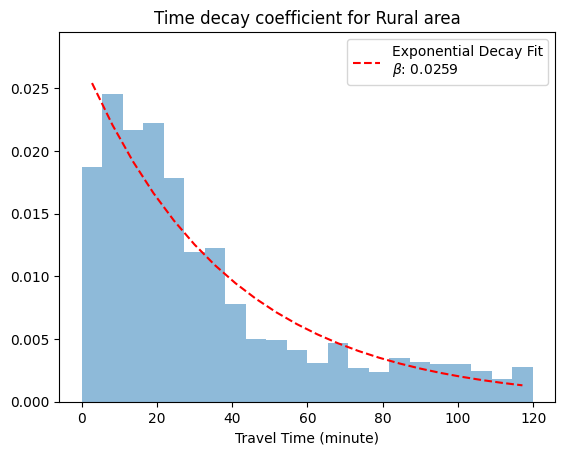

Time decay coefficient: 0.0259
R-squared value: 0.89


In [8]:
# Read in data
ttd = pd.read_csv("D:/M.S. GIS/Georgia Tech/GRA/CQGRD/Job_Accessibility/Rural.csv")

# Filter out work trips that are larger than 2 hours
ttd = ttd.loc[ttd['Total_TravelTime'] <= 120]

# Interquartile travel time for Metropolitan census tracts
q75, q25 = np.percentile(ttd['Total_TravelTime'], [75 ,25])
iqr = q75 - q25

# Optimal bin width
onb = 2 * iqr/(len(ttd['Total_TravelTime']) ** (1/3))

# Optimal number of bins for rural area estimate
opb_r = round((np.max(ttd['Total_TravelTime']) - np.min(ttd['Total_TravelTime'])) / onb)
print(f'Optimal number of bins: {opb_r}')

# Define exponential decay function
def exponential_decay(x, a, b):
    return a * np.exp(-b * x)

# Extracting histogram data
counts, bin_edges = np.histogram(ttd['Total_TravelTime'], bins=opb_r, density=True)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Fit the data to the exponential decay function using bin centers as x values
popt, pcov = curve_fit(exponential_decay, bin_centers, counts, p0=(1, 0.01))

# Extract the parameters
a_fit, b_fit = popt

# Plot the histogram
plt.hist(ttd['Total_TravelTime'], bins=opb_r, density=True, alpha=0.5)

# Plot the fitted exponential decay curve using bin centers
plt.plot(bin_centers, exponential_decay(bin_centers, *popt), 'r--', label=f'Exponential Decay Fit\n$\\beta$: {b_fit:.4f}')

# Set y-axis limits to ensure both histogram and fit line are visible
plt.xlabel('Travel Time (minute)')
plt.ylim(0, max(counts)*1.2)

# Show the plot with legend
plt.title('Time decay coefficient for Rural area')
plt.legend()
plt.savefig('D:/Capstone/Rural.png', bbox_inches='tight')
plt.show()

# Calculate R-squared value
predicted_values = exponential_decay(bin_centers, *popt)
R_squared = r2_score(counts, predicted_values)

print(f'Time decay coefficient: {round(b_fit, 4)}')
print("R-squared value:", round(R_squared, 2))
